In [12]:
import numpy as np 
import pandas as pd 
import dicom
import os
import re
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.losses import *
from keras.optimizers import *
from keras.layers import *
from keras.models import *

## Load Training and Testing Data

In [13]:
# Util functions 
def get_X(img_arrays):
    """
    Combine all images into one array for training.
    Param
    -----
    img_arrays: a list of image arrays
    
    Return
    -----
    x: normalized array of all images arrays for training
    """
    x = np.stack(img_arrays)[..., None] # create 4-d array
    x = np.repeat(x, 3, axis=-1)  #Repeat to have 3 channels, b/c RGB has three channels
    x = (x - np.mean(x)) / np.std(x)  #normalization
    return x


def mapper(imgs, gt):
    """
    Param
    ------
    imgs: list of image paths
    csvfile: train or test csvfile
    Return
    ------
    y: a list of breast density ground truth labels corresponding to the input imgs
    """
    y = np.zeros(shape=len(imgs), dtype=int)
    brdensity = gt.groupby(by='patient_id')['breast_density'].median()
    for i, img in enumerate(imgs):
        pid = re.findall(r'P_[0-9]*', img)[0]
        den = brdensity[pid] - 1
        y[i] = den
    return y

In [14]:
# Load images
train_np = "./train_np/" # Change Me: train directory with all img numpy files
train_imgnames = [os.path.join(train_np, i) for i in os.listdir(train_np) if i.endswith(".npy")]
train_imgs = [np.load(i) for i in train_imgnames]

test_np = "./test_np/" # Change Me: test direc with all img numpy files
test_imgnames = [os.path.join(test_np, i) for i in os.listdir(test_np) if i.endswith(".npy")]
test_imgs = [np.load(i) for i in test_imgnames]

In [15]:
# Load ground truth labels
train_csv = pd.read_csv("./mass_case_description_train_set.csv") # Change Me!
test_csv = pd.read_csv("./mass_case_description_test_set.csv") #Change Me!

In [16]:
train_x = get_X(train_imgs)
test_x = get_X(test_imgs)

train_y = mapper(train_imgnames, train_csv)
test_y = mapper(test_imgnames, test_csv)

## Display Dicom Images

In [17]:
train_imgs[0].shape

(299, 299)

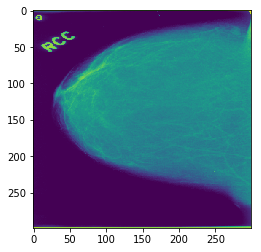

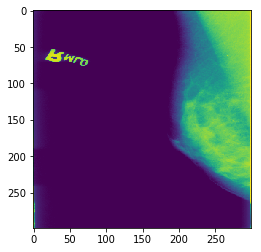

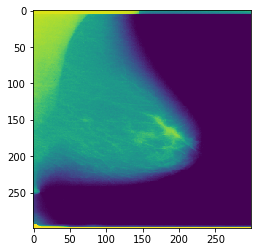

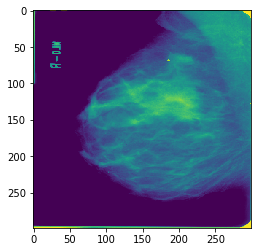

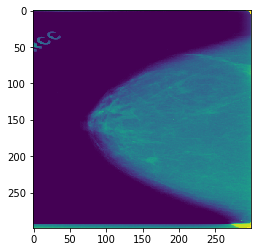

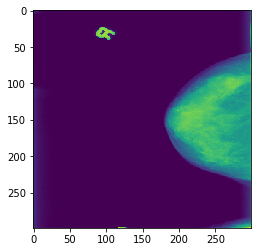

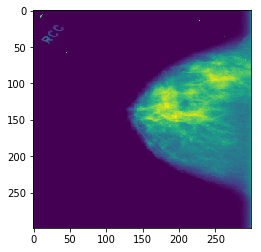

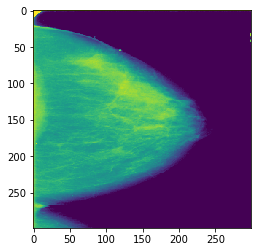

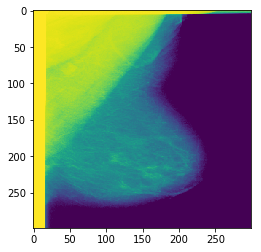

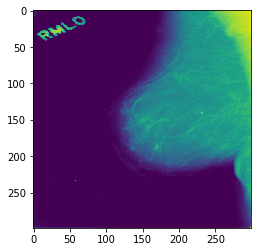

In [18]:
# 10 images from training
for i in range(10):
    plt.imshow(train_imgs[i]/255,)
    plt.show()

## Train ResNet50

In [141]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=7829044)

In [142]:
model = ResNet50(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
# add a global spatial average pooling layer
x = model.output
x = GlobalAveragePooling2D()(x)
# Fully-connected layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
predictions

<tf.Tensor 'dense_11/Softmax:0' shape=(?, 4) dtype=float32>

In [104]:
model = Model(inputs=model.input, outputs=predictions)
optimizer = Adam()
loss = 'sparse_categorical_crossentropy'
model.compile(optimizer, loss, metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=1024, epochs = 3, validation_data=(X_valid, y_valid))

Train on 115 samples, validate on 29 samples
Epoch 1/3
115/115 [==============================] - 503s 4s/step - loss: 3.9902 - acc: 0.2870 - val_loss: 1.2101 - val_acc: 0.4138
Epoch 2/3
115/115 [==============================] - 489s 4s/step - loss: 3.0323 - acc: 0.3217 - val_loss: 11.6717 - val_acc: 0.2759
Epoch 3/3
115/115 [==============================] - 422s 4s/step - loss: 1.6355 - acc: 0.4000 - val_loss: 11.6717 - val_acc: 0.2759


## Test and Evaluation

In [105]:
y_pred = model.predict(test_x)

In [146]:
y_test = sklearn.preprocessing.label_binarize(test_y, classes=[0, 1, 2, 3])

In [147]:
y_test = y_test.astype(int)

In [148]:
y_pred = y_pred.astype(int)

In [154]:
#Precision and Recall
target_names=['class 1', 'class 2', 'class 3', 'class 4']
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.13      1.00      0.24         6
          1       0.00      0.00      0.00        15
          2       0.00      0.00      0.00        19
          3       0.00      0.00      0.00         5

avg / total       0.02      0.13      0.03        45



/Users/Mithomas/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
